# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# **Install**

In [ ]:
!pip install torchmetrics

# **Imports 📢**

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import Accuracy
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm


import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.1.4
cv2 --> 4.10.0
PIL --> 10.4.0
sklearn --> 1.5.2
torch --> 2.4.1+cu121
torchvision --> 0.19.1+cu121
tqdm --> 4.66.5
torchmetrics --> 1.4.2


# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Copy & Unzip the Dataset**

In [ ]:
!tar -xzf '/content/drive/MyDrive/project_0_age_estimation/data/UTKFace.tar.gz' -C '/content/'

## 🟠 EDA

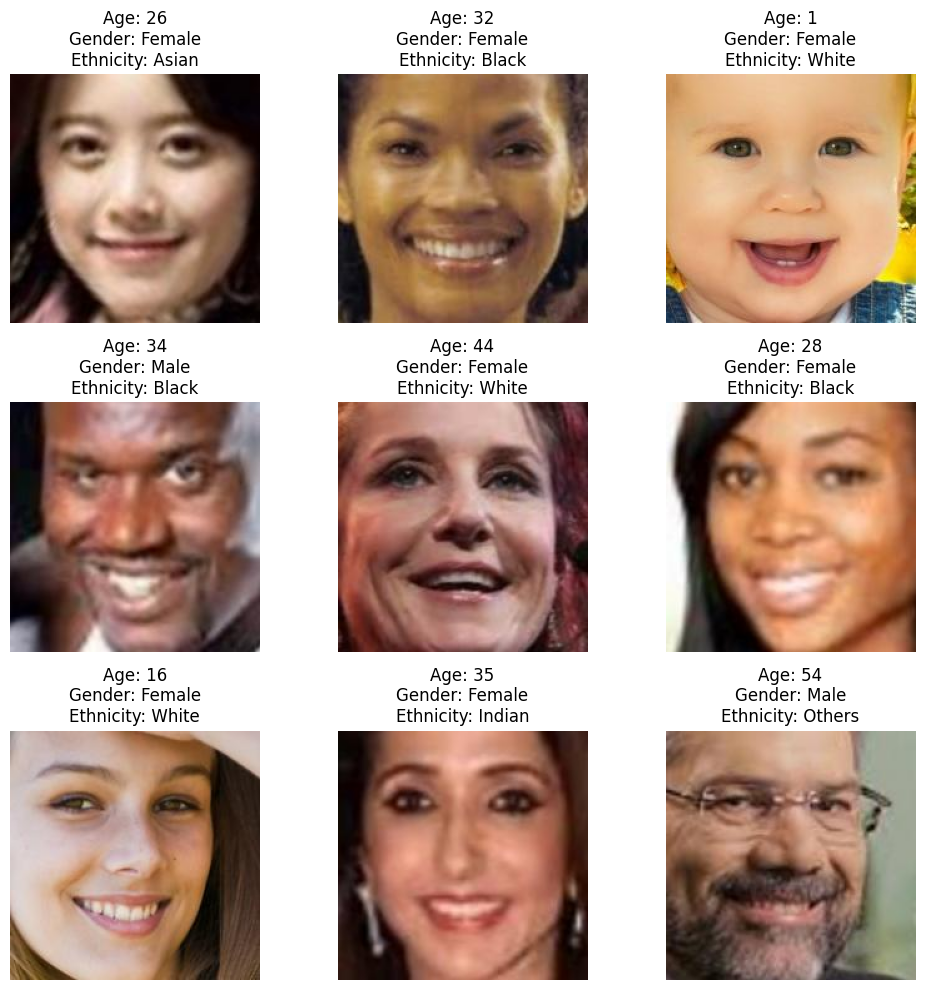

In [ ]:
dataset_folder = '/content/UTKFace/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

### 🟡 Create a csv file which contains labels




In [ ]:
dataset_folder = '/content/UTKFace/'
image_files = os.listdir(dataset_folder)

ages = []
genders = []
ethnicitys = []
image_names = []

for image_file in image_files:
  image_path = os.path.join(dataset_folder, image_file)

  split = image_file.split('_')
  if len(split) > 3:
    age = (int(split[0]))
    gender = (int(split[1]))
    ethnicity = (int(split[2]))
    gender = 'Male' if int(gender) == 0 else 'Female'
    ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]
    ages.append(age)
    image_names.append(image_file)
    genders.append(gender)
    ethnicitys.append(ethnicity)
  else:
    print(image_path)


/content/UTKFace/39_1_20170116174525125.jpg.chip.jpg
/content/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/content/UTKFace/61_1_20170109150557335.jpg.chip.jpg


In [ ]:
for i in [image_names ,ages ,ethnicitys ,genders] :
  print(len(i))

23705
23705
23705
23705


In [ ]:
image_names = pd.Series(list(image_names), name = 'Image_name')
ages = pd.Series(list(ages), name = 'age')
ethnicitys = pd.Series(list(ethnicitys), name = 'ethnicity')
genders = pd.Series(list(genders), name = 'gender')

In [ ]:
df = pd.concat([image_names, ages, ethnicitys, genders], axis=1)
df.head()
df

,Image_name,age,ethnicity,gender
0,50_0_0_20170104211706898.jpg.chip.jpg,50,White,Male
1,24_1_3_20170104223049680.jpg.chip.jpg,24,Indian,Female
2,32_0_2_20170116185010991.jpg.chip.jpg,32,Asian,Male
3,26_1_3_20170119192546129.jpg.chip.jpg,26,Indian,Female
4,6_0_0_20170110215623387.jpg.chip.jpg,6,White,Male
...,...,...,...,...
23700,24_1_0_20170117150642259.jpg.chip.jpg,24,White,Female
23701,24_0_3_20170104214346781.jpg.chip.jpg,24,Indian,Male
23702,1_1_0_20170109193014933.jpg.chip.jpg,1,White,Female
23703,32_0_2_20170104192811687.jpg.chip.jpg,32,Asian,Male


In [ ]:
df.Image_name

,Image_name
0,50_0_0_20170104211706898.jpg.chip.jpg
1,24_1_3_20170104223049680.jpg.chip.jpg
2,32_0_2_20170116185010991.jpg.chip.jpg
3,26_1_3_20170119192546129.jpg.chip.jpg
4,6_0_0_20170110215623387.jpg.chip.jpg
...,...
23700,24_1_0_20170117150642259.jpg.chip.jpg
23701,24_0_3_20170104214346781.jpg.chip.jpg
23702,1_1_0_20170109193014933.jpg.chip.jpg
23703,32_0_2_20170104192811687.jpg.chip.jpg


### 🟡 Plot histogram for age

Text(0, 0.5, 'Frequency')

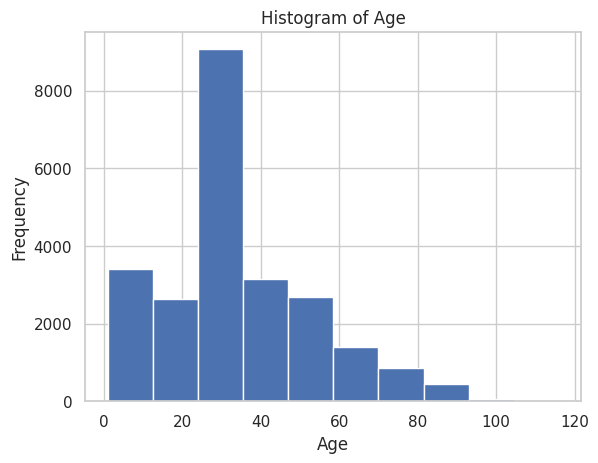

In [ ]:
plt.hist(df.age)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

### 🟡 Plot histogram for gender

Text(0, 0.5, 'Frequency')

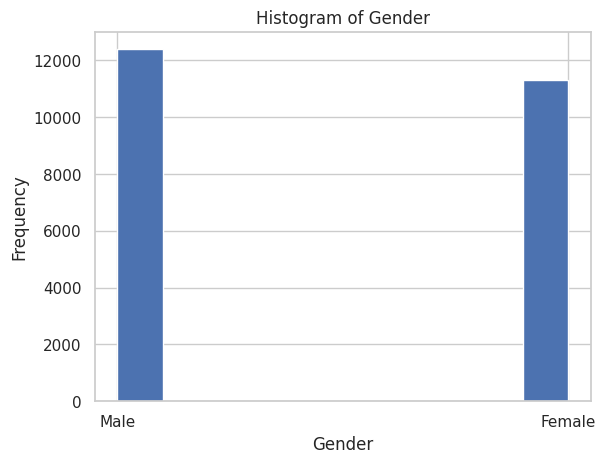

In [ ]:
plt.hist(df.gender)
plt.title('Histogram of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')

### 🟡 Plot histogram for ethnicity

Text(0, 0.5, 'Frequency')

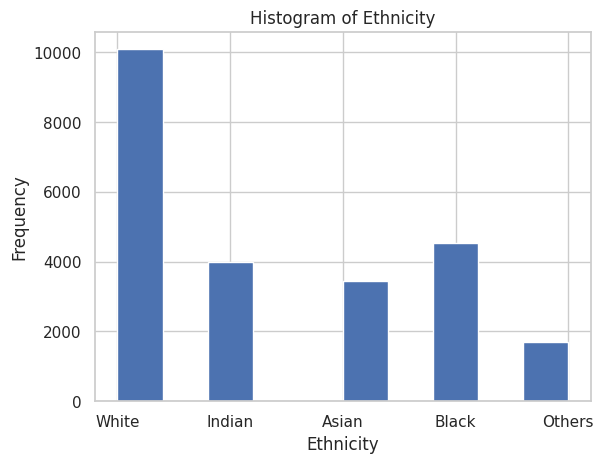

In [ ]:
plt.hist(df.ethnicity)
plt.title('Histogram of Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')

### 🟡 Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [ ]:
pd.crosstab(index=df.gender, columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1859,2208,1714,932,4601
Male,1575,2318,2261,760,5477


### 🟡 Create violin plots and box plots for age, separately for men and women.

Text(0, 0.5, 'Gender')

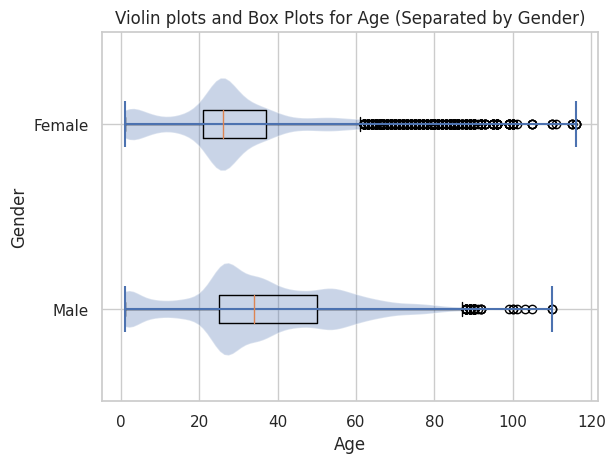

In [ ]:
col = 'gender'
plt.boxplot([df.age[df[col] == var] for var in df[col].unique()], labels=df[col].unique(), vert=False);
plt.violinplot([df.age[df[col] == var] for var in df[col].unique()], vert=False);
plt.title('Violin plots and Box Plots for Age (Separated by Gender)')
plt.xlabel('Age')
plt.ylabel('Gender')

### 🟡 Create violin plots and box plots for age, separately for each ethnicity.

Text(0, 0.5, 'Ethnicity')

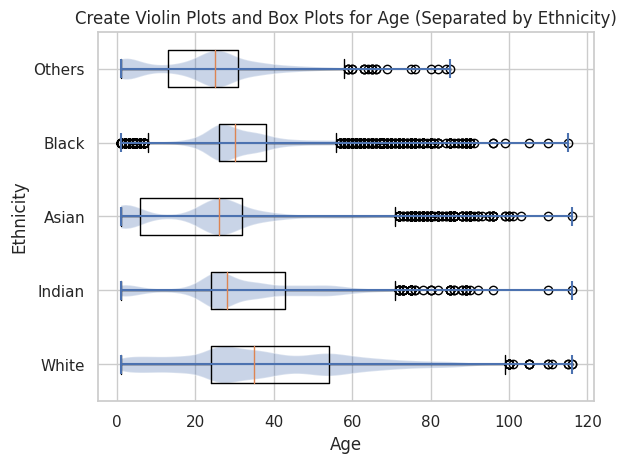

In [ ]:
col = 'ethnicity'
plt.boxplot([df.age[df[col] == var] for var in df[col].unique()], labels=df[col].unique(), vert=False);
plt.violinplot([df.age[df[col] == var] for var in df[col].unique()], vert=False);

plt.title('Create Violin Plots and Box Plots for Age (Separated by Ethnicity)')
plt.xlabel('Age')
plt.ylabel('Ethnicity')

## 🟠 Split datasets

In [ ]:
df_train, df_test = train_test_split(df, test_size= 0.2, train_size= 0.8, random_state=23)
df_train, df_valid = train_test_split(df_train, test_size=0.2,train_size = 0.8, random_state=23)
print(len(df_train))
print(len(df_valid))
print(len(df_test))

15171
3793
4741


###🟡 Plot histograms for age in the training, validation, and test sets.

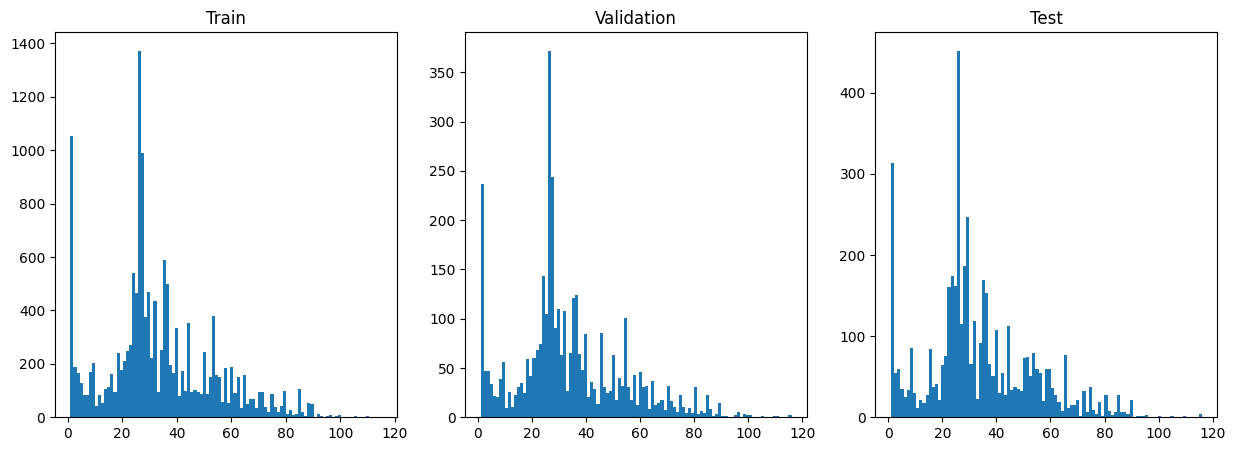

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

### 🟡 Save the training, validation, and test sets in separate CSV files.

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define transformations

In [ ]:
transform_train = transforms.Compose([
                              transforms.Resize((128, 128)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomRotation(15),
                              transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.40],
                                                  std= [0.229, 0.224, 0.225]),])

transform_test = transforms.Compose([
                              transforms.Resize((128, 128)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.40],
                                                  std= [0.229, 0.224, 0.225]),])

transform = transforms.Compose([
                              transforms.Resize((128, 128))])

## 🟠 Custom dataset

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, phase, transform=None):
      self.transform = transform
      root = (f"{root_dir}/{phase}_set.csv")
      self.data = pd.read_csv(root)

      self.image_path = self.data.Image_name
      self.images_list = [f'/content/UTKFace/{i}' for i in self.image_path]

      self.age = torch.LongTensor(self.data.age).squeeze()
      self.gender = self.data.gender
      self.ethnicity = self.data.ethnicity

    def __getitem__(self, idx):

      img = self.images_list[idx]
      image = Image.open(img).convert('RGB')
      image = self.transform(image)

      age = self.age[idx].item()
      gender = self.gender[idx]
      ethnicity = self.ethnicity[idx]

      return image, age, gender, ethnicity

    def __len__(self):
      return len(self.data)

In [ ]:
train_set = UTKDataset('/content/' ,'train' ,transform_train)
valid_set = UTKDataset('/content/','valid',transform_test)
test_set = UTKDataset('/content/','test', transform_test)

In [ ]:
len(train_set), len(valid_set), len(test_set)

(15171, 3793, 4741)

In [ ]:
train_set.age.shape

torch.Size([15171])

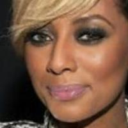

In [ ]:
train_set2 = UTKDataset('/content/' ,'train' ,transform )
train_set2.__getitem__(3)[0]

## 🟠 Define dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
image, age, gender, ethnicity = next(iter(train_loader))
image.shape, age

(torch.Size([64, 3, 128, 128]),
 tensor([35, 27, 88, 26, 40, 65, 45, 75, 30, 26, 18, 23, 15, 66, 28, 26, 17, 26,
         35,  1, 85, 45, 12, 24, 26, 39, 26, 40, 26,  1, 40,  1, 70, 23, 72, 20,
         25, 32, 27, 26, 43, 21, 14, 60, 64,  5,  6, 32, 85, 28, 58, 32, 54, 21,
         24, 21,  1, 36, 60, 45, 25, 60,  3, 45]))

# 🔴 **Model**

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V1)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

In [ ]:
model = AgeEstimationModel()
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model(torch.randn(1,3,128,128)).shape

torch.Size([1, 1])

In [ ]:
num_trainable_params(model)

23.510081

In [ ]:
lr = 0.001
wd = 1e-4
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.L1Loss()

# 🔴 **Train ➰**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm.tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets, _, _ in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

# 🔴 **Evaluation ➰**

In [ ]:
def validation(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets, _, _) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item())
  return loss_valid.avg

# 🔴 **Training Process 〽️**

## 🟠 Main Loop

In [ ]:
model = AgeEstimationModel()
model

In [ ]:
model = model.to(device)
lr = 0.0001
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.L1Loss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                            train_loader,
                                            loss_fn,
                                            optimizer,
                                            epoch)
# Validation
  loss_valid = validation(model,
                                valid_loader,
                                loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'/content/drive/MyDrive/project1_age_estimation/data/model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 238/238 [01:42<00:00,  2.32batch/s, loss=3.54]


Valid: Loss = 5.105



Epoch 1: 100%|██████████| 238/238 [01:42<00:00,  2.33batch/s, loss=3.46]


Valid: Loss = 5.188



Epoch 2: 100%|██████████| 238/238 [01:43<00:00,  2.30batch/s, loss=3.41]


Valid: Loss = 5.189



Epoch 3: 100%|██████████| 238/238 [01:42<00:00,  2.31batch/s, loss=3.3]


Valid: Loss = 5.103



Epoch 4: 100%|██████████| 238/238 [01:43<00:00,  2.29batch/s, loss=3.54]


Valid: Loss = 5.134



Epoch 5: 100%|██████████| 238/238 [01:42<00:00,  2.33batch/s, loss=3.33]


Valid: Loss = 5.098



Epoch 6: 100%|██████████| 238/238 [01:43<00:00,  2.31batch/s, loss=3.34]


Valid: Loss = 5.335



Epoch 7: 100%|██████████| 238/238 [01:42<00:00,  2.33batch/s, loss=3.21]


Valid: Loss = 5.106



Epoch 8: 100%|██████████| 238/238 [01:43<00:00,  2.30batch/s, loss=3.2]


Valid: Loss = 5.086



Epoch 9: 100%|██████████| 238/238 [01:42<00:00,  2.32batch/s, loss=3.11]


Valid: Loss = 5.134



## 🟠 Plot

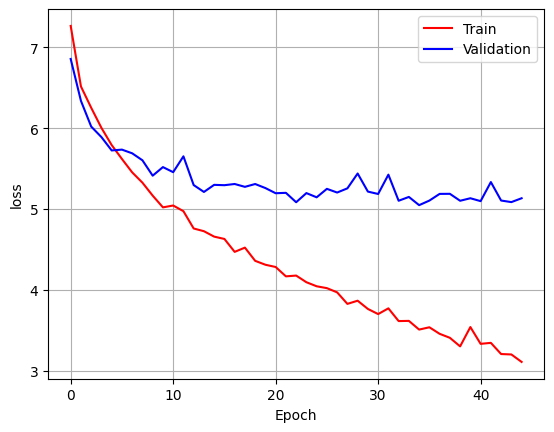

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()